In [1]:
import cudf
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np

from dask.distributed import Client
import dask_cudf
from dask_cuda import LocalCUDACluster

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45597 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 23.17 GiB


In [3]:
print(cluster)

LocalCUDACluster(7c11e916, 'tcp://127.0.0.1:39163', workers=1, threads=1, memory=23.17 GiB)


In [2]:
results = {
    "cpu": {},
    "gpu": {}
}

scale_factors = ["x0_1", "x0_5", "x1", "x5", "x10", "x20"]

### CPU

In [3]:
for scale_factor in scale_factors:
    results['cpu'][scale_factor] = {}
    results['cpu'][scale_factor]["io_opt"] = {}
    results['cpu'][scale_factor]["queries"] = {}

    start = time()
    cpu_df = pd.read_csv("../data/raw/online_retail_II_"+scale_factor+".csv")
    end = time()

    results["cpu"][scale_factor]["io_opt"]["load_csv"] = end-start

    start = time()
    cpu_df.info()
    end = time()

    results["cpu"][scale_factor]["io_opt"]["info"] = end-start

    start = time()
    cpu_df.describe(include="O")
    end = time()

    results["cpu"][scale_factor]["io_opt"]["describe"] = end-start

    start = time()
    cpu_df.groupby("Country").Price.sum()
    end = time()

    results["cpu"][scale_factor]["queries"]["q1"] = end-start

    start = time()
    cpu_df.groupby("Invoice").Price.sum()
    end = time()

    results["cpu"][scale_factor]["queries"]["q2"] = end-start

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      100000 non-null  object 
 1   StockCode    100000 non-null  object 
 2   Description  99130 non-null   object 
 3   Quantity     100000 non-null  int64  
 4   InvoiceDate  100000 non-null  object 
 5   Price        100000 non-null  float64
 6   Customer ID  72861 non-null   float64
 7   Country      100000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      500000 non-null  object 
 1   StockCode    500000 non-null  object 
 2   Description  497184 non-null  object 
 3   Quantity     500000 non-null  int64  
 4   InvoiceDate  500000 non-nu

## GPU

In [4]:
for scale_factor in scale_factors:
    print("Testing with SF="+scale_factor)
    print()
    gpu_df = None

    results['gpu'][scale_factor] = {}
    results['gpu'][scale_factor]["io_opt"] = {}
    results['gpu'][scale_factor]["queries"] = {}

    start = time()
    gpu_df = cudf.read_csv("../data/raw/online_retail_II_"+scale_factor+".csv")
    end = time()

    results["gpu"][scale_factor]["io_opt"]["load_csv"] = end-start

    start = time()
    gpu_df.info()
    end = time()

    results["gpu"][scale_factor]["io_opt"]["info"] = end-start

    start = time()
    gpu_df.describe(include="O")
    end = time()

    results["gpu"][scale_factor]["io_opt"]["describe"] = end-start

    start = time()
    gpu_df.groupby("Country").Price.sum()
    end = time()

    results["gpu"][scale_factor]["queries"]["q1"] = end-start

    start = time()
    gpu_df.groupby("Invoice").Price.sum()
    end = time()

    results["gpu"][scale_factor]["queries"]["q2"] = end-start

Testing with SF=x0_1

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Invoice      100000 non-null  object
 1   StockCode    100000 non-null  object
 2   Description  99130 non-null   object
 3   Quantity     100000 non-null  int64
 4   InvoiceDate  100000 non-null  object
 5   Price        100000 non-null  float64
 6   Customer ID  72861 non-null   float64
 7   Country      100000 non-null  object
dtypes: float64(2), int64(1), object(5)
memory usage: 10.9+ MB
Testing with SF=x0_5

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Invoice      500000 non-null  object
 1   StockCode    500000 non-null  object
 2   Description  497184 non-null  object
 3   Quantity     500000 non-null  int64
 4

MemoryError: std::bad_alloc: CUDA error at: /home/edomin/miniforge3/envs/thesis/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorMemoryAllocation out of memory

In [10]:
# gpu_df = cudf.DataFrame.from_pandas(pd.read_csv("../data/raw/online_retail_II_x20.csv"))

MemoryError: std::bad_alloc: CUDA error at: /home/edomin/miniforge3/envs/thesis/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorMemoryAllocation out of memory

## PLOTS

In [7]:
def plot(sf, cpu_io, gpu_io, cpu_queries, gpu_queries):
    # PLOT 1
    labels = ['Load\ndataset', '.info()', '.describe()']
    # cpu_values = [i[1] for i in results["cpu"]["x1"]["io_opt"].items()]
    # gpu_values = [i[1] for i in results["gpu"]["x1"]["io_opt"].items()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax1 = plt.subplot(1, 2, 1)
    ax1.bar(x - width/2, cpu_io, width, label='CPU')
    ax1.bar(x + width/2, gpu_io, width, label='GPU')

    ax1.set_ylabel('seconds')
    ax1.set_title('I/O operations by time')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()

    # PLOT 2
    labels = ['Q1', 'Q2']
    # cpu_queries = [i[1] for i in results["cpu"]["x1"]["queries"].items()]
    # gpu_queries = [i[1] for i in results["gpu"]["x1"]["queries"].items()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax2 = plt.subplot(1, 2, 2)
    ax2.bar(x - width/2, cpu_queries, width, label='CPU')
    ax2.bar(x + width/2, gpu_queries, width, label='GPU')

    ax2.set_title('Queries by time')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    plt.suptitle("Test with SF="+sf)
    plt.show()

In [ ]:
print(results)

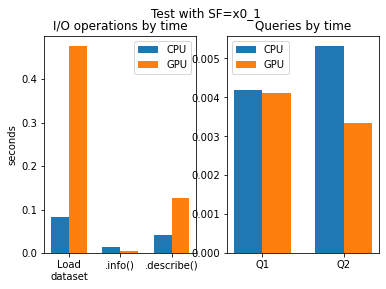

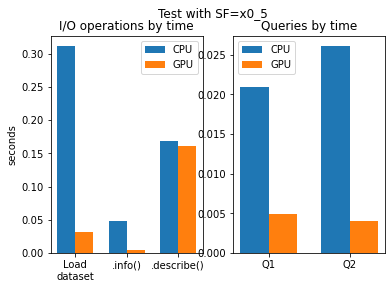

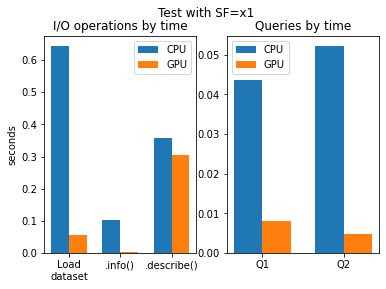

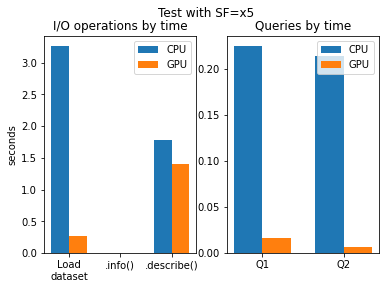

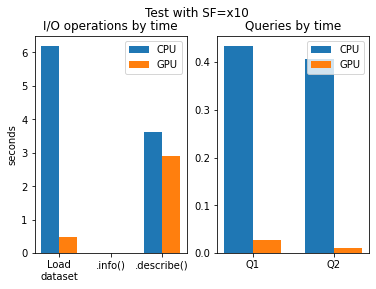

In [8]:
for scale_factor in scale_factors:
    if scale_factor != "x20":
        plot(
            scale_factor,
            [i[1] for i in results["cpu"][scale_factor]["io_opt"].items()],
            [i[1] for i in results["gpu"][scale_factor]["io_opt"].items()],
            [i[1] for i in results["cpu"][scale_factor]["queries"].items()],
            [i[1] for i in results["gpu"][scale_factor]["queries"].items()]
        )

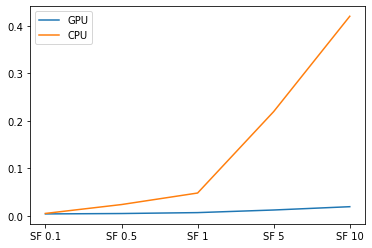

In [10]:
cpu = []
gpu = []

for scale_factor in scale_factors:
    if scale_factor != "x20":
        cpu.append(mean([i[1] for i in results["cpu"][scale_factor]["queries"].items()]))
        gpu.append(mean([i[1] for i in results["gpu"][scale_factor]["queries"].items()]))

activity = ["SF 0.1", "SF 0.5", "SF 1", "SF 5", "SF 10", "SF 20"]

fig, ax = plt.subplots()
ax.plot(activity, gpu, label="GPU")
ax.plot(activity, cpu, label="CPU")
ax.legend()

plt.show()